# Regression

회귀(regression)은 가격이나 확률 같이 연속된 출력 값을 예측하는 것이다.

## Predict fuel efficiency: 자동차 연비 예측

In [2]:
import pathlib
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

devices = tf.config.list_physical_devices('GPU')
print(devices)
try:
    tf.config.experimental.set_memory_growth(devices[0], True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download the dataset

In [3]:
dataset_path = tf.keras.utils.get_file(
    'd:\\dataset\\auto-mpg.data',
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    )
print(dataset_path)

d:\dataset\auto-mpg.data


In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
dataset.shape

(398, 8)

### Clean the dataset

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


### Split the data into training and test sets

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.shape)
print(test_dataset.shape)

(314, 10)
(78, 10)


### Inspect the data

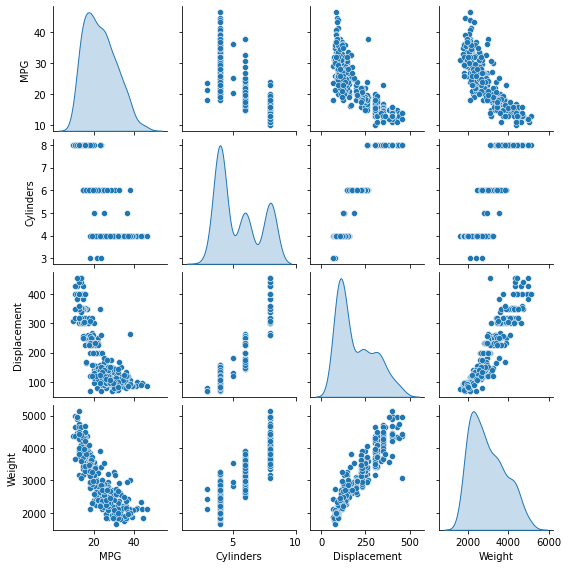

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde', height=2)
plt.show()

In [12]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

### Normalization

각 특성들은 다양한 척도와 범위를 가지고 있다. 이를 정규화해주는 것이 좋다.

그 이유는 모델은 특성에 가중치를 곱하며 학습을 하기 때문에 **모델의 출력의 규모와 기울기의 규모는 입력값에 영향을 받기 때문**이다. 물론 모델은 정규화를 하지 않고도 수렴할 수 있지만, **정규화는 학습을 훨씬 더 안정적으로 만든다.**

*'ont-hot' 특성은 정규화해도 이점이 없다.*

In [14]:
train_dataset.describe().T[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


### The Normalization layer

`tf.keras.layers.Normalization` 레이어는 모델에 정규화를 추가하는 깔끔하고 간단한 방법이다.
- 평균과 분산을 계산하고 레이어에 저장한다.
- 레이어가 호출되면 각 특성이 독립적으로 정규화된 입력 데이터를 반환한다.

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example: ', first)
    print()
    print('Normalized: ', normalizer(first).numpy())

First example:  [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### Linear regression

심층 신경망 모델을 만들기 전에, 단일 변수와 다수 변수를 사용한 선형 회귀를 사용해 보자.

#### Linear regression with one variable

단일 변수 선형 회귀로 'horsepower(마력)'을 통해 'MPG'를 예측해보자.

단일 변수 선형 회귀 모델은 두 단계를 거친다.
1. `tf.keras.layers.Normalization` 레이어를 사용하여 단일 변수 정규화
2. 선형 변환$(y = mx + b)$을 적용하여 선형 레이어(`tf.keras.layers.Dense`)를 사용하여 1개의 출력 생성

입력값의 수는 `input_shape` 인수로 설정하거나, 모델이 처음 실행될 때 자동으로 설정할 수 있다.

- 먼저 단일 변수로 구성된 numpy 배열을 만들고, 'nomalization'을 인스턴스하고, 단일 변수에 적용한다.*

In [17]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [18]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


처음 10개의 데이터에 대한 학습되지 않은 모델의 예측 결과.

In [19]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 1s 621ms/step


array([[-1.1613535 ],
       [-0.65590066],
       [ 2.1435301 ],
       [-1.6279253 ],
       [-1.4724014 ],
       [-0.57813865],
       [-1.7445682 ],
       [-1.4724014 ],
       [-0.38373375],
       [-0.65590066]], dtype=float32)

`Model.compile`을 통해 학습 절차를 설정.
- **가장 중요한 인자는 `loss`와 `optimizer`이며, 이들은 최적화될 대상과 방법을 정의하기 때문이다.**

In [20]:
horsepower_model.compile(
    loss=tf.losses.MeanAbsoluteError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.05)
)

In [21]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: total: 8.53 s
Wall time: 6.52 s


### Visualization

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802278,4.199222,95
96,3.803056,4.202876,96
97,3.803756,4.190312,97
98,3.808859,4.179860,98
99,3.803574,4.197960,99


In [23]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

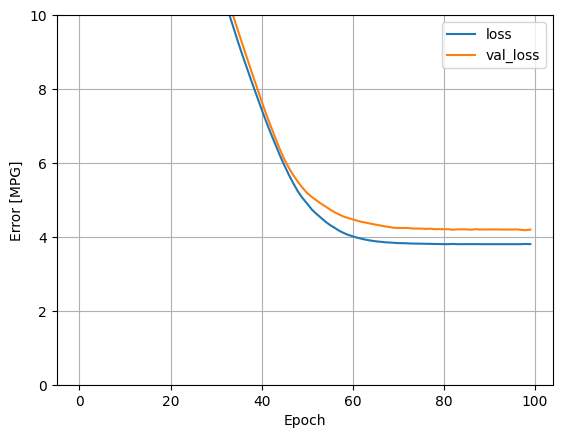

In [24]:
plot_loss(history)

In [25]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels)

3/3 [==============================] - 0s 4ms/step - loss: 3.6729


In [26]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [27]:
def plot_horsepower(x, y):
    plt.scatter(train_dataset['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

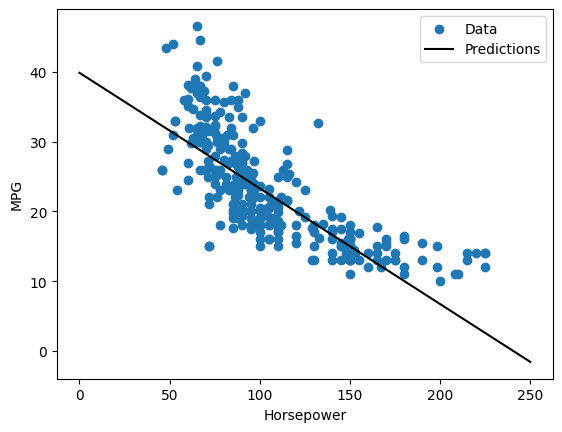

In [28]:
plot_horsepower(x, y)

#### Linear regression with multiple inputs

단일 변수 예측과 거의 동일한 설정을 사용하여 다수의 변수를 기반으로 예측을 수행할 수 있다.

이 모델은 ($y = mx + b$)에서 $m$이 행렬이고 $b$가 벡터라는 점을 제외하면 동일하다.

- 위에서 정의해 놓은 'normalizer'를 적용한 모델을 만든다.

In [29]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

- 입력 batch에 대해 `Model.predict`를 호출하면 각 데이터에 대한 `units=1` 출력이 생성된다.

In [30]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 50ms/step


array([[ 0.0362321 ],
       [-0.41156703],
       [ 2.1316817 ],
       [-0.08409874],
       [-2.1695385 ],
       [-0.13209563],
       [-2.4828343 ],
       [-2.9029188 ],
       [ 0.17385368],
       [-2.2159462 ]], dtype=float32)

- 모델은 호출하면 가중치 행렬이 만들어진다.

In [31]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.5530083 ],
       [-0.52657086],
       [ 0.6596949 ],
       [ 0.15776455],
       [-0.69336045],
       [ 0.097902  ],
       [-0.24547136],
       [-0.3561965 ],
       [ 0.20787972]], dtype=float32)>

모델 학습.

In [32]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = tf.keras.losses.MeanAbsoluteError()
)

In [33]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: total: 9.8 s
Wall time: 7.95 s


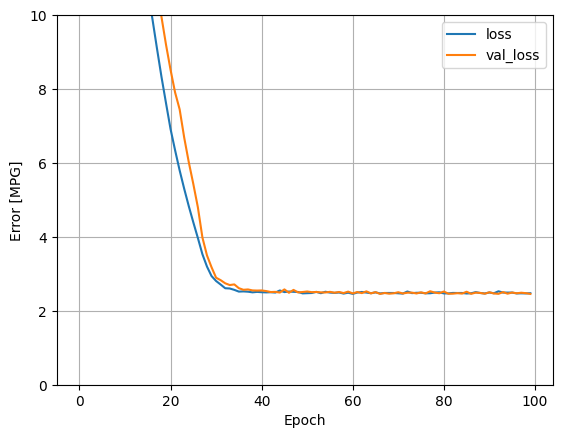

In [34]:
plot_loss(history)

In [35]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

In [36]:
test_results

{'horsepower_model': 3.6728785037994385, 'linear_model': 2.465451955795288}

### Regression with a deep neural network (DNN)

이제 단일 변수 및 다수 변수를 이용한 DNN 모델을 구현해보자.

코드는 모델이 일부 '숨겨진' 비선형 레이어를 포함하도록 확장된다는 점을 제외하면 기본적으로 동일하다. 여기서 '숨겨진'이라는 것은 입력 또는 출력에 직접 연결되지 않음을 의미한다.

설계 모델에는 위의 선형 모델보다 몇 개의 레이어를 더 포함한다.
- 이전과 같은 정규화 레이어
- `ReLU`라는 비선형성 활성화 함수를 포함하고 있는 `hidden` 비선형 레이어 두 개
-  선형 단일 출력 `Dense` 레이어

In [37]:
def build_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )
    return model

#### Regression using a DNN and a single input

입력 변수로 'Horsepower'만 사용하고 정규화 레이어는 'horsepower_normalizer'를 사용하여 모델을 만든다.

In [38]:
dnn_horsepower_model = build_compile_model(horsepower_normalizer)

In [39]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [40]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    validation_split=0.2,
    verbose=0
)

CPU times: total: 10.2 s
Wall time: 8.08 s


- 이 모델은 선형 단일 변수로 학습한 'horsepower_model' 보다 약간 더 우수하다는 것을 확인할 수 있다.

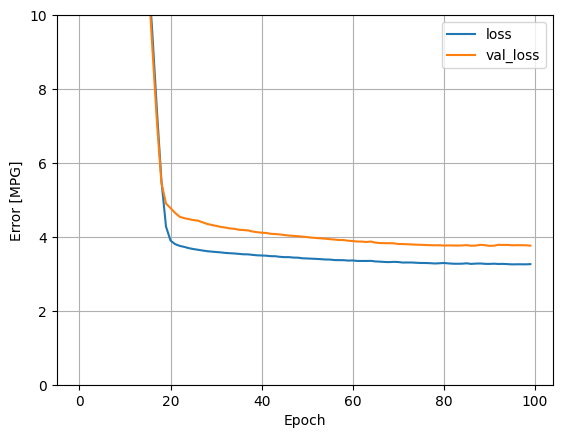

In [41]:
plot_loss(history)

- 예측을 'horsepower' 특성으로 시각화하면 이 모델이 `hidden` 레이어에서 제공되는 '비선형성'을 어떻게 활용하는지 확인할 수 있다.

In [42]:
nx = int(train_features.shape[0] * 0.8)

x = tf.linspace(0.0, nx-1, nx)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


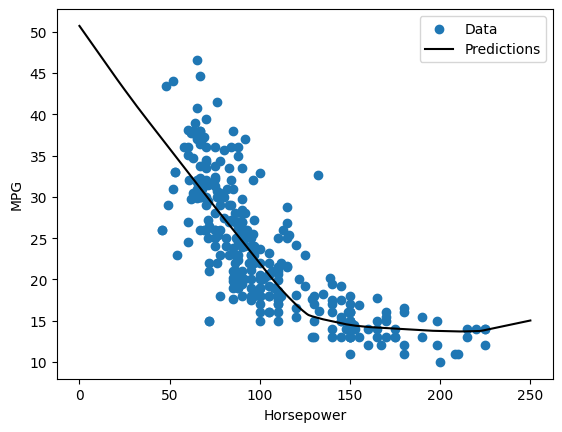

In [43]:
plot_horsepower(x, y)

In [44]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

#### Regression using a DNN and multiple inputs

In [45]:
dnn_model = build_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [46]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    epochs=100,
    verbose=0
)

CPU times: total: 9.61 s
Wall time: 7.97 s


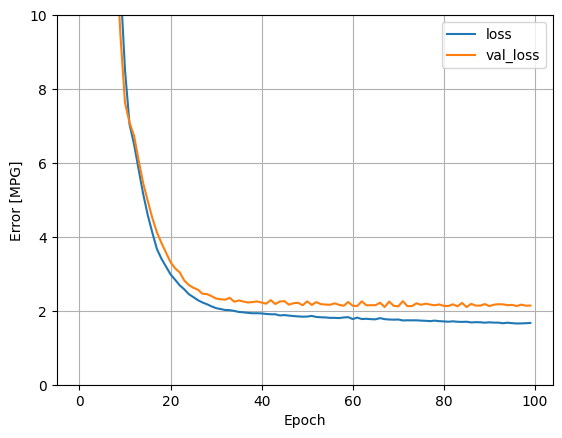

In [47]:
plot_loss(history)

In [48]:
test_results['dnn_model'] = dnn_model.evaluate(
    test_features,
    test_labels,
    verbose=0
)

### Performance

모든 모델의 학습이 끝났으므로, 테스트 세트의 평가 성능을 비교해보자.

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error']).T

,Mean absolute error
horsepower_model,3.672879
linear_model,2.465452
dnn_horsepower_model,2.947211
dnn_model,1.686660


#### Make predictions

이제 `Model.prediction`을 사용하여 테스트 세트를 예측하고 `loss`를 검토해보자.
- 모델이 합리적으로 잘 예측하는지를 확인할 수 있다.

3/3 [==============================] - 0s 3ms/step


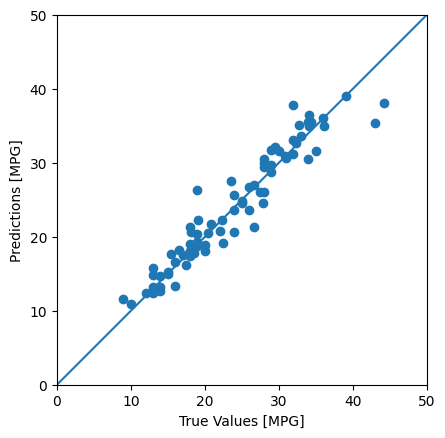

In [50]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

- 오류의 분포를 확인해보자.

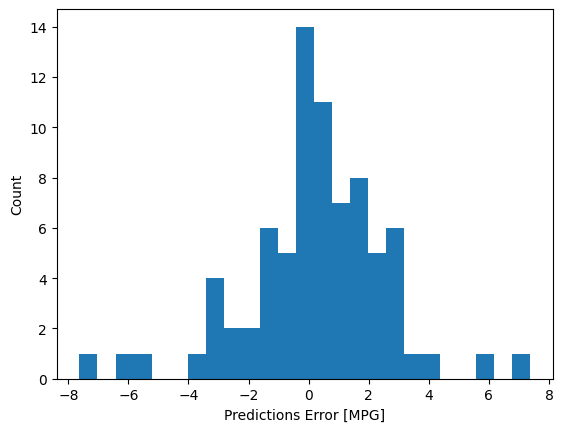

In [51]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Predictions Error [MPG]')
_ = plt.ylabel('Count')

- 모델의 성능이 만족스럽다면 모델을 저장할 수 있다.

In [52]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


- 모델을 다시 로드하면 동일한 출력을 얻을 수 있다.

In [53]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features,
    test_labels,
    verbose=0
)

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error']).T

,Mean absolute error
horsepower_model,3.672879
linear_model,2.465452
dnn_horsepower_model,2.947211
dnn_model,1.686660
reloaded,1.686660


### Conclusion

회귀 문제를 다뤄보았다. 다음은 도움이 될 수 있는 추가 정보이다.
- MSE(Mean squared error) 및 MAE(Mean absolute error)는 회귀 문제에 사용되는 일반적인 손실 함수이다.
    - MAE는 이상값에 덜 민감하다.
    - 분류 문제에는 다른 손실 함수가 사용된다.
- 마찬가지로 회귀에 사용되는 'evaluation metrics'는 분류와 다르다.
- 숫자로 구성된 특성들이 다른 범위의 값으로 입력되어 있는 경우, 각 특성을 동일한 범위로 조정해야 한다. (정규화)